<a href="https://colab.research.google.com/github/hd9189/Facial_Recognition/blob/main/Facial_verification_with_SNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Setup**

**1.1 Install Dependencies**

In [131]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

**Import Dependencies**

In [132]:
#import standard dependencies
import cv2
import os
import random
# good to work for arrays, good for tensorflow
import numpy as np
# can help visualize an image
from matplotlib import pyplot as plt

In [133]:
import tensorflow as tf

# import tensorflow dependencies
# usually people use the sequential tensorflow api, but functional tensorflow api is much more flexible in terms of hardcore processing
# building a siamanese nerual network. comparing two images and seeing if their the same
# passing 2 images at the same time, and finding the similarity between the two images
# importing functional api

# most imported = Model(Input=[input image, verification image], Output=[1,0])
from tensorflow.keras.models import Model
# lots of layer types for NN
# Layer=high level class (creating a custom layer)
# Conv2D (standard layer) Called a convoluntional layer usually for CNN, forming convolutions
# Dense, a fully connected layer
# MaxPooling2D, Pool layers together and shrinks info together, taking max value overa certain region
# Input, determines what you input into NN, input(shape=)
# Flatten, takes all info form a layer and flattens it into more simpler
# Import tensorflow dependencies - Functional API
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

**Setup GPU Growth**

In [134]:
# Avoid out of memory errors, by setting GPU memory consumption Growth

# accessing all GPUs on machine
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    # setting memory growth 
    tf.config.experimental.set_memory_growth(gpu, True)

**Create Folder Structures**

In [135]:
# create 3 folders for data
# anchor (real time input), positive, and negative

# setup paths
POS_PATH = os.path.join('data', "positive")
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [136]:
# making directories

# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

# **2. Collect Positives and Anchors**

Notes:

Anchor and positive data will be collected through the webcam via opencv, while the negative data are going to be through a data set

A SNS basically has 2 comparision NN, where there is a distance function determining whether or not the images when comapred to the anchor look the same.

In Part two, we will be collecting the data

**Untar Labelled Faces in the Wild Dataset**

In [137]:
# # Uncompress TAR GZ Labelled Faces in the Wild Dataset

# !tar -xf lfw.tgz

In [138]:
# # Move LFW Images from folder to the following respository data/negative, done by redirecting the path

# # gives directory/folder name for every single folder in 'lfw' folder
# for directory in os.listdir('lfw'):
#   # loops through every image in every folder and get path
#   for file in os.listdir(os.path.join('lfw', directory)):
#     # manipulate directory
#     EX_PATH = os.path.join('lfw', directory, file)
#     NEW_PATH = os.path.join(NEG_PATH, file)
#     os.replace(EX_PATH, NEW_PATH)

**Collect Positive and Anchor Classes**

In [139]:
# Import uuid library to generate unique image names
import uuid

In [140]:
# # Establish a connection to the webcam
# cap = cv2.VideoCapture(0)
# while cap.isOpened(): 
#     ret, frame = cap.read()
   
#     # Cut down frame to 250x250px, (y,x)
#     frame = frame[200:200+250,600:600+250, :]
    
#     # Collect anchors when click a
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         # Create the unique file path and placing in folder
#         imgname = os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg')
#         # Write out anchor image
#         cv2.imwrite(imgname, frame)
    
#     # Collect positives when click p
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         # Create the unique file path 
#         imgname = os.path.join(POS_PATH, f'{uuid.uuid1()}.jpg')
#         # Write out positive image
#         cv2.imwrite(imgname, frame)
    
#     # Show image back to screen
#     cv2.imshow('Image Collection', frame)
    
#     # Breaking gracefully
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break

# # good to help forcefully stop cv2 webcam, in case of freezing
# # Release the webcam
# cap.release()
# # Close the image show frame
# cv2.destroyAllWindows

In [141]:
# print frame for testing
# plt.imshow(frame)

# **3. Load and Preprocess Images**

** Get Image Directories**

In [142]:
# getting images within directory
# Basically get 300 files that have the PATH and the .jpg in the name
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [143]:
def preprocess(file_path):
    # Reading image from file path
    byte_img = tf.io.read_file(file_path)
    # loading image
    img = tf.io.decode_jpeg(byte_img)
    # preprocessing steps
    # resize image
    img = tf.image.resize(img, (100,100))
    # scaling image to be between 1 and 0
    img /= 255.0 
    return img

**Create Labelled Dataset**

(anchor, positive) => [1,1,1,1,1]
(anchor, negative) => [0,0,0,0,0]

In [144]:
# .zip allows to zip everything up and iterate everything at the same time

# creating a dataset using anchor, positive/negative, and an array of 1s or 0s that matches the shape of the anchor
# saying that if we compare the anchor to positive, we want it to be 1, if we compare anchor to negative, we want it to be 0
postives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

# joining positives and negatives dataset together
data = postives.concatenate(negatives)

In [145]:
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple


(b'data/anchor/624eaf04-ab1a-11ed-b2e9-f2189828324b.jpg',
 b'data/positive/6d81c1b8-ab1a-11ed-b2e9-f2189828324b.jpg',
 1.0)

**Build, Train, and Test Partition**

In [146]:
def preprocess_twin(input_img, validation_img, label):
    # input_img -> anchor, validation_img -> positive/negative
    return(preprocess(input_img), preprocess(validation_img), label)



In [147]:
# Build Dataloader pipline
data = data.map(preprocess_twin) #applies function to the entire data set
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [148]:
# Training partition
train_data = data.take(round(len(data)*.7))
# but 16 images in one group to train at one time
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [149]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# **4. Model Creation**

**Embedding Layer (for NN to read image)**

In [150]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [151]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 17, 17, 128)       26

In [152]:
# Used to take input of the image
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    # reads the image, taking it apart piece by piece by pixel size.
    # 64 10x10 parts
    c1 = Conv2D(64, (10,10), activation='relu')(inp) # passing inp into c1
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [153]:
embedding = make_embedding()


In [154]:
# SNN layer
embedding.summary()


Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 17, 17, 128)       26

**4.2 Distance Layer**

In [155]:
# Siamese L1 Distance class
# Sort of like a custom NN layer
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

**Siamese Model**

In [156]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [157]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [158]:
siamese_layer = L1Dist()


In [159]:
distances = siamese_layer(inp_embedding, val_embedding)


In [160]:
classifier = Dense(1, activation='sigmoid')(distances)


In [161]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [162]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer, final output, 1 or 0
    classifier = Dense(1, activation='sigmoid')(distances)
    
    # All the layers together
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [163]:
siamese_model = make_siamese_model()

In [164]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# **5. Training**

Basic flow for training on one batch:
1. make prediction
2. Calculate loss
3. Derive gradeints
4. Calculate new weights and apply

**Setting up Loss and Optimizer**

In [165]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [166]:
# learning rate of 1e-4 --> 0.0001
opt = tf.keras.optimizers.Adam(1e-4)

**Establish Checkpoints**

If something goes wrong during training, we can go back to these checkpoints

Note to self: To reload from the checkpoint, you can use model.load('path_to_checkpoint').
this will load the pre trained weights into existing model

In [167]:
# create directory for training checkpoints
checkpoint_dir = './training_checkpoints'

# creastion checkpoint prefix, all start with ckpt
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


**Build, Train, Step Function**

Each batch in the dataset is comprised of 16 samples, each of which contians an anchor image, a pos or neg image, and a label


In [168]:
# decorator to complie a function into a callable tf graph
# make the entire NN into a graph to train more efficiently
@tf.function
def train_step(batch):

    # record operations for automatic differentiation
    with tf.GradientTape() as tape:

        # Get anchor and pos/neg image (features)
        X = batch[:2]

        # Get label
        y = batch[2]

        # Forward pass
        # NOTE: important to have traning=True as some layers only activate when this happens
        ypred = siamese_model(X, training=True)
        # Calculate loss, passing through y=true, ypred=predicted outcome
        loss = binary_cross_loss(y ,ypred)
    print(loss)
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    #Calculate updated wights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

**Training Loop**

In [169]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

**Train Model**

In [170]:
# number of training datasets
EPOCHS = 50

In [171]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 12s 330ms/step
0.23731254 0.13300492 1.0

 Epoch 2/50
27/27 [==============================] - 9s 335ms/step
0.26959968 0.5637255 0.9583333

 Epoch 3/50
27/27 [==============================] - 9s 329ms/step
0.23505077 0.96744186 0.962963

 Epoch 4/50
27/27 [==============================] - 9s 315ms/step
0.008363188 0.96713614 0.9951691

 Epoch 5/50
27/27 [==============================] - 8s 313ms/step
0.2317776 0.98536587 0.9950739

 Epoch 6/50
27/27 [==============================] - 9s 342ms/step
0.108097136 0.96744186 1.0

 Epoch 7/50
27/27 [==============================] - 9s 327ms/step
0.21130939 0.9665072 0.9950739

 Epoch 8/50
27/27 [==============================] - 8s 315ms/step
0.0008724269 0.97044337 1.0

 Epoch 9/50
27/27 [==============================] - 8s 308ms/

# **Evalutate Model**

**Import Metrics**

In [172]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

**Make Predictions**

In [173]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [174]:
y_hat = siamese_model.predict([test_input, test_val])


1/1 [==============================] - 0s 24ms/step


In [175]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]

**Calculate Metrics**

In [176]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [177]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [178]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 26ms/step
1.0 1.0


 **Visualizing Results**

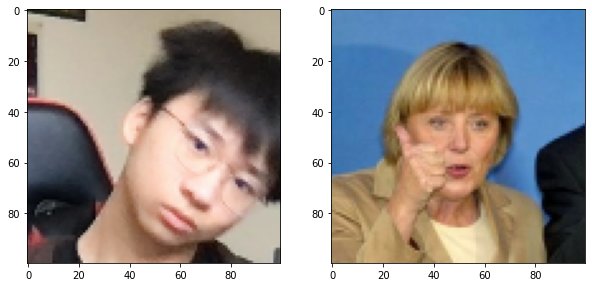

In [179]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

# **Save Model**

In [180]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [181]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [182]:

# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 164ms/step


array([[9.9999487e-01],
       [9.9999976e-01],
       [9.1938057e-07],
       [1.8931894e-09]], dtype=float32)

In [183]:

# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# **Real Time Test**

**Verification Function**

In [184]:

# model: SNS model
# detection_threshold: metric above which a predicted is considered positive
# verficaiton_threshold: proportion of (positive predictions/total positive samples)
def verify(model, detection_threshold, verification_threshold):
  results = []
  # looping through a list of every image in verification image
  for image in os.listdir(os.path.join('application_data', 'verification_images')):

    # using preprocess function to convert the image to the right size and scale it
    input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))

    # do the same for verification image
    validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

    # make predictions
    result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
    results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified


**OpenCV Verification**

In [189]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[200:200+250,600:600+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):

        # add image to folder, and remakes path
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()